In [1]:
import os
import numpy as np
import pandas as pd

os.chdir("../..")
import utils

In [2]:
outputfolder = os.getcwd() + '/output/'
datafolder = os.getcwd() + '/datasets/PTB-XL/'
sampling_rate = 100
task = 'subdiagnostic'
experiment_name = 'exp1.1'

In [3]:
data, raw_labels = utils.load_dataset(datafolder, sampling_rate=sampling_rate)
labels = utils.compute_label_aggregations(raw_labels, datafolder, task)
data, labels, Y, _ = utils.select_data(data, labels, task, 0, outputfolder+experiment_name+'/data/')

In [4]:
X_test = data[labels.strat_fold == 10]
y_test = Y[labels.strat_fold == 10]

X_val = data[labels.strat_fold == 9]
y_val = Y[labels.strat_fold == 9]

X_train = data[labels.strat_fold <= 8]
y_train = Y[labels.strat_fold <= 8]

n_classes = y_train.shape[1]

print(f"This experiment has {n_classes} classes")

This experiment has 23 classes


In [5]:
X_train_lead1 = X_train[:,:,0]
X_test_lead1 = X_test[:,:,0]
X_val_lead1 = X_val[:,:,0]

## Design and fit Inception

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, MaxPool1D, Input, Dense, GlobalAveragePooling1D
from keras.layers import concatenate
from keras.models import Model

In [7]:
def inception_block(prev_layer):
    
    conv1=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv1=BatchNormalization()(conv1)
    conv1=Activation('relu')(conv1)
    
    
    conv3=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv3=BatchNormalization()(conv3)
    conv3=Activation('relu')(conv3)
    
    conv3=Conv1D(filters = 64, kernel_size = 3, padding = 'same')(conv3)
    conv3=BatchNormalization()(conv3)
    conv3=Activation('relu')(conv3)
   
    
    conv5=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv5=BatchNormalization()(conv5)
    conv5=Activation('relu')(conv5)
    
    conv5=Conv1D(filters = 64, kernel_size = 5, padding = 'same')(conv5)
    conv5=BatchNormalization()(conv5)
    conv5=Activation('relu')(conv5)
    
    pool= MaxPool1D(pool_size=3, strides=1, padding='same')(prev_layer)
    convmax=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(pool)
    convmax=BatchNormalization()(convmax)
    convmax=Activation('relu')(convmax)
    
    layer_out = concatenate([conv1, conv3, conv5, convmax], axis=1)
    
    return layer_out

def inception_model(input_shape):
    X_input=Input(input_shape)
    
    #X = ZeroPadding1D(3)(X_input)
    
    X = Conv1D(filters = 64, kernel_size = 1, padding = 'same')(X_input)
    #X = MaxPool1D(pool_size=3, strides=2, padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv1D(filters = 64, kernel_size = 1, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    
    X = inception_block(X)
    X = MaxPool1D(pool_size=2, strides=4, padding='same')(X)
    X = inception_block(X)
    X = MaxPool1D(pool_size=2, strides=4, padding='same')(X)
    X = inception_block(X)
    X = MaxPool1D(pool_size=2, strides=4, padding='same')(X)
    X = inception_block(X)
    X = MaxPool1D(pool_size=2, strides=4, padding='same')(X)
    
    
    X = inception_block(X)
    X = MaxPool1D(pool_size=2, strides=4, padding='same')(X)
    """X = inception_block(X)
    X = MaxPool1D(pool_size=2, strides=4, padding='same')(X)
    X = inception_block(X)
    X = MaxPool1D(pool_size=2, strides=4, padding='same')(X)
    X = inception_block(X)
    X = MaxPool1D(pool_size=2, strides=4, padding='same')(X)
    X = inception_block(X)
    X = MaxPool1D(pool_size=2, strides=4, padding='same')(X)
    X = inception_block(X)
    X = MaxPool1D(pool_size=2, strides=4, padding='same')(X)"""
    
    X = GlobalAveragePooling1D()(X)
    X = Dense(64,activation='relu')(X)
    X = Dense(64,activation='relu')(X)
    X = Dense(n_classes,activation='softmax')(X)
    
    model = Model(inputs = X_input, outputs = X, name='Inception')
    
    return model

In [8]:
inception = inception_model(input_shape=(1000,12))

In [9]:
inception.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy',threshold=0.5),
                      tf.keras.metrics.Recall(name='recall'),
                      tf.keras.metrics.AUC(num_thresholds=200,
                                           curve="ROC",
                                           summation_method='interpolation',
                                           name="AUC",
                                           multi_label=True,
                                           label_weights=None)]
)

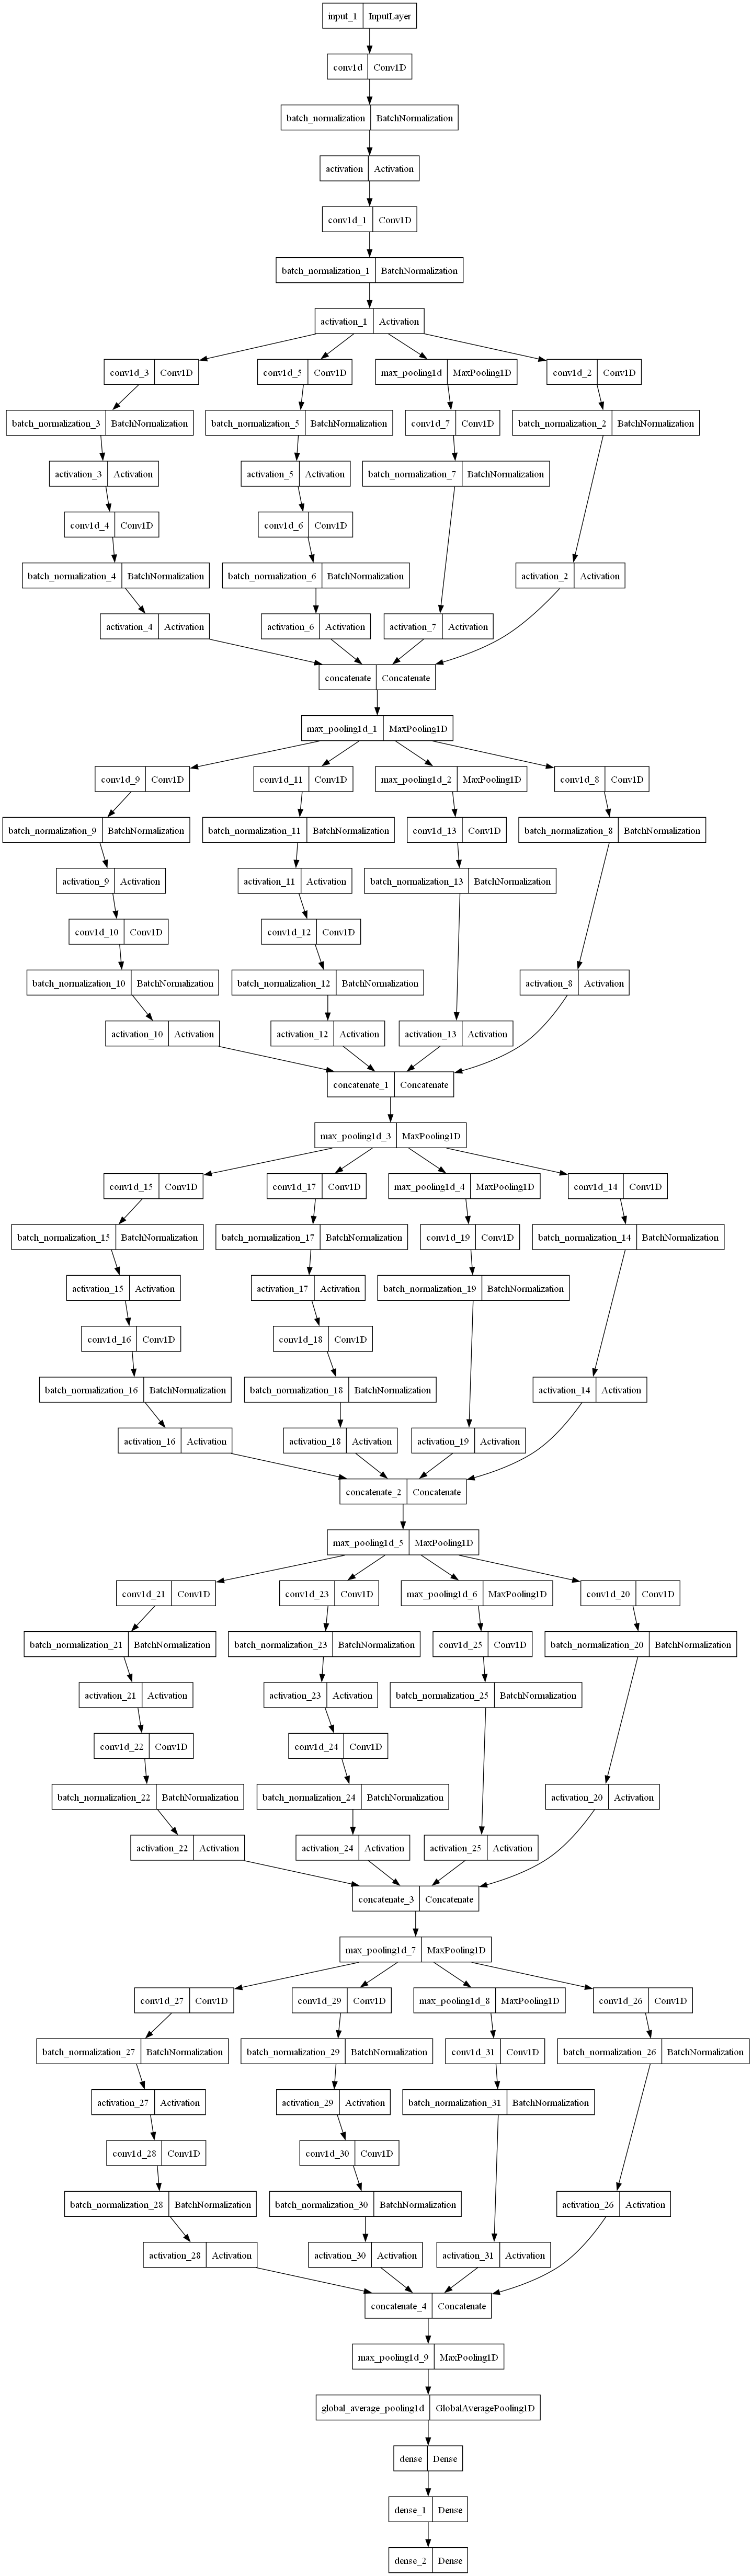

In [10]:
from keras.utils import plot_model
plot_model(inception)

In [11]:
batchsize=10

In [12]:
inception.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=batchsize)

Epoch 1/30
1709/1709 [==============================] - 1080s 623ms/step - loss: 0.1458 - accuracy: 0.9502 - recall: 0.2748 - AUC: 0.7377 - val_loss: 0.1308 - val_accuracy: 0.9524 - val_recall: 0.2725 - val_AUC: 0.7756
Epoch 2/30
1709/1709 [==============================] - 994s 581ms/step - loss: 0.1180 - accuracy: 0.9555 - recall: 0.3693 - AUC: 0.7846 - val_loss: 0.1383 - val_accuracy: 0.9510 - val_recall: 0.3695 - val_AUC: 0.7552
Epoch 3/30
1709/1709 [==============================] - 1039s 608ms/step - loss: 0.1102 - accuracy: 0.9584 - recall: 0.4251 - AUC: 0.7925 - val_loss: 0.1145 - val_accuracy: 0.9571 - val_recall: 0.4212 - val_AUC: 0.7844
Epoch 4/30
1709/1709 [==============================] - 1136s 665ms/step - loss: 0.1053 - accuracy: 0.9603 - recall: 0.4531 - AUC: 0.7981 - val_loss: 0.1145 - val_accuracy: 0.9563 - val_recall: 0.4169 - val_AUC: 0.8017
Epoch 5/30
1004/1709 [================>.............] - ETA: 7:32 - loss: 0.1020 - accuracy: 0.9609 - recall: 0.4650 - AUC: 0